# Suggested solution to Inaugral Project

In [54]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

# Import functions created to solve the project
import inauguralproject as ip

# Use import lib to reload changes in inauguralproject.py
import importlib
#importlib.reload(ip)

#### Setting model parameters

In [55]:
mp = {'phi': 0.3, 'epsilon': 0.5, 'r': 0.03, 'tau_g': 0.012, 'tau_p': 0.004, 'p_bar': 3}

## Question 1

See the file **project_module.py** for the implementation of functions to solve the consumer's problem.  
Below, we solve the consumer's problem for exposition using the module.

In [56]:
# The price index is equal to 1 
p = 1

# We solve the problem for a consumer with cash-on-hand = 0.3 (ie. 300,000 DKK)
m = 0.3

# Call function to solver consumer problem
c,h,u = ip.solve_housing(m, mp, print_sol=True, p=p)

c          =  0.210
h          =  2.500
user_costs =  0.090
u          =  0.442
m - user_costs - c = 0.0000


#### Utility over a grid

For exposition, we plot the utilities over a grid of housing given m = 0.3

In [57]:
# Housing grid
hs = np.linspace(0.1, 8, 100)

# Consumption grid
cs = [ip.choose_c(h, m, mp, p) for h in hs]

# Utils
us = [ip.u_func(c, h, mp) for c,h in zip(cs,hs)]

# Taxes paid
taus = [ip.tau(h, mp, p) for h in hs]

# Choices at yielding highest utility on grid
max_u = max(us)
hstar = hs[[u == max_u for u in us]]
cstar = ip.choose_c(hstar, m, mp, p)

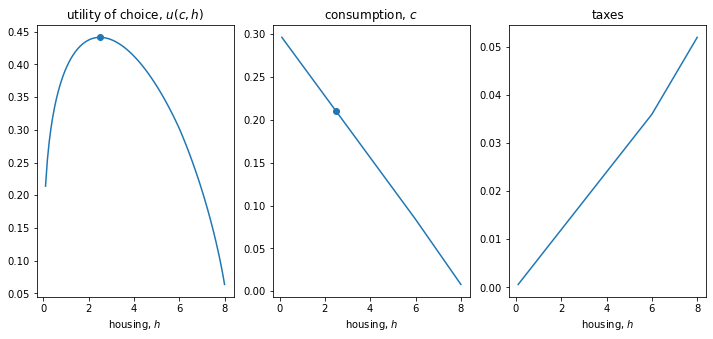

In [58]:
# Plotting over grid to investigate solution
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,3,1)

ax.plot(hs, us)
ax.set_title('utility of choice, $u(c,h)$')
ax.set_xlabel('housing, $h$')
ax.scatter(hstar,max_u)

ax = fig.add_subplot(1,3,2)
ax.plot(hs, cs)
ax.set_title('consumption, $c$')
ax.set_xlabel('housing, $h$')
ax.scatter(hstar,cstar)

ax = fig.add_subplot(1,3,3)
ax.plot(hs, taus)
ax.set_title('taxes')
ax.set_xlabel('housing, $h$')

plt.show()

# Question 2

Plotting $c^{\star}$ and $h^{\star}$ as $m$ ranges from 0.4 to 1.5 

In [59]:
# a. Grid over cash on hand
ms = np.linspace(0.4, 1.5, 100)    
cs_star = []
hs_star = []

# b. Solve model over grid
for m in ms:
    c_star,h_star,u = ip.solve_housing(m, mp, print_sol = False, p=p)
    cs_star.append(c_star)
    hs_star.append(h_star)

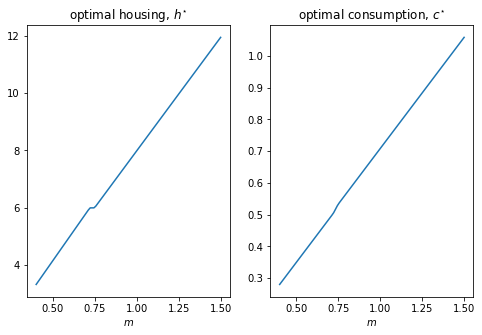

In [60]:
# Plotting over grid to investigate solution
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(1,2,1)
ax.plot(ms, hs_star)
ax.set_title('optimal housing, $h^{\star}$')
ax.set_xlabel('$m$')

ax = fig.add_subplot(1,2,2)
ax.plot(ms, cs_star)
ax.set_title('optimal consumption, $c^{\star}$')
ax.set_xlabel('$m$')

plt.show()

Notice the kinks in both *policy functions* (ie. the optimal choice given constraints). These are induced by the discrete cut-off in the progressive housing tax. 

# Question 3

In [61]:
# Create population of consumers according to the distribution of cash-on-hand
N = 10000
np.random.seed(1) # Setting the seed
ms = np.random.lognormal(-0.40, 0.35, size = N)

In [63]:
# Calculate the optimal housing and corresponding tax revenues of consumers. See module for specifications
tax_revenues, hs_star = ip.tax_revenues(mp, ms)

# Print results
print(f'Average housing tax revenue (1000s): {tax_revenues.mean()*1e3:2.3f}')

# Store avg revenues in variable
avg_tax_revenue_base = tax_revenues.mean()

Average housing tax revenue (1000s): 36.327


# Question 4

In [64]:
# New parameters after tax reform
mp_reform = {'phi': 0.3, 'epsilon': 0.8, 'r': 0.03, 'tau_g': 0.01, 'tau_p': 0.009, 'p_bar': 8}

# Calculate the optimal housing and corresponding tax revenues of consumers after the tax reform.
tax_revenues_reform, hs_star_reform = ip.tax_revenues(mp_reform, ms)

# Print results
print(f'Average housing tax revenue after reform (1000s): {tax_revenues_reform.mean()*1e3: 2.3f}')
print(f' minimum tax bill: {tax_revenues_reform.min() * 1e3: 2.3f}, \n maximum tax bill: {tax_revenues_reform.max() * 1e3: 2.3f}')

Average housing tax revenue after reform (1000s):  45.036
 minimum tax bill:  11.774, 
 maximum tax bill:  212.087


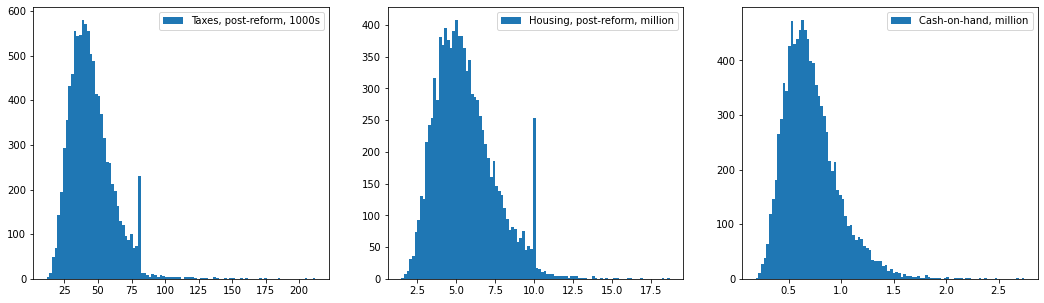

In [67]:
# Plotting the distribution of outcomes
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1,3,1)
ax.hist(tax_revenues_reform*1e3, bins = 100, label = 'Taxes, post-reform, 1000s')
ax.legend(loc='upper right')

ax = fig.add_subplot(1,3,2)
ax.hist(hs_star_reform, bins = 100, label = 'Housing, post-reform, million')
ax.legend(loc='upper right')

ax = fig.add_subplot(1,3,3)
ax.hist(ms, bins = 100, label = 'Cash-on-hand, million')
ax.legend(loc='upper right')

plt.show()

The *bunching* you are witnessing in the distributions stems from the kinks in the policy functions seen above. The abrupt change in marginal tax rates stops agents from increasing their consumption of housing in a certain cash-on-hand range.  

# Question 5

In [68]:
# Create a new dictionary to avoid making changes in the previous parameter dicts
mp_reform_eq = mp_reform.copy() 

We need an objective function that indicates how far off we are from equalizing tax revenues in the two tax schemes

In [69]:
# a. Objective function for equalizing tax revenues 
def objective(tau_g, tax_target, ms, mp):
    mp['tau_g'] = tau_g # As the optimizer calls the objective with new versions of tau_g, this element has to be continuously updated in mp.
    new_taxes, hs_stars = ip.tax_revenues(mp, ms) # Solve for tax revenues at new guess of equalizing tau_g
    return tax_target - new_taxes.mean()

# b. Define the target of the root finding procedure (the previous average tax revenue) and call optimizer.
tax_target = avg_tax_revenue_base
tau_g0 = 0.005 # Initial guess of tau_g
tax_reform_sol = optimize.root(objective, tau_g0, args=(tax_target, ms, mp_reform_eq)) 

# c. Unpack solution from root finding
mp_reform_eq['tau_g'] = tax_reform_sol.x[0]

# d. Check solution  
taxes_post_reform, hs_stars = ip.tax_revenues(mp_reform_eq, ms)
avg_tax_revenue_reform = taxes_post_reform.mean() 
revenue_diff = tax_target - avg_tax_revenue_reform

# e. Print results
print('New tau_g to equalize tax revenue after reform: ', tau_g_eq)
print(f'Average tax revenue before equalizing reform, thousands: {tax_target * 1e3: 2.3f}')
print(f'Average tax revenue after equalizing reform, thousands:  {avg_tax_revenue_reform * 1e3: 2.3f}')
print(f'Difference in average revenues:  {revenue_diff: 2.8f}')

New tau_g to equalize tax revenue after reform:  [0.00767094]
Average tax revenue before equalizing reform, thousands:  36.327
Average tax revenue after equalizing reform, thousands:   36.327
Difference in average revenues:   0.00000000
